# Reproduce chi2 spectrum fit

I tried to reproduce the spectral fit I made with Christoph a few weeks ago using a new source.

## Load Data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pprint import pprint
import astropy.units as u
from astropy.units import Quantity

In [2]:
from gammapy.catalog import SourceCatalog3FGL, SourceCatalogObject3FGL

cat = SourceCatalog3FGL()

# This time I will pick "Dragonfly" as my source
source = cat['3FGL J2021.1+3651'] # a.k.a. PSR J2021+3651
data = source.flux_points.table

# Flux units
data['dnde'] = data['dnde'].to('cm-2 s-1 MeV-1')

# Create flux error
dnde_err = data['dnde'] * (data['flux_errn'] / data['flux'])
data['dnde_err'] = dnde_err.to(data['dnde'].unit)

data.info()

FileNotFoundError: [Errno 2] No such file or directory: '$GAMMAPY_EXTRA\\datasets\\catalogs\\fermi\\gll_psc_v16.fit.gz'

In [3]:
cols = ['e_ref', 'dnde', 'dnde_err']
data[cols]

# These will be the same for any source

e_ref,dnde,dnde_err
MeV,1 / (cm2 MeV s),1 / (cm2 MeV s)
float64,float64,float64
173.205080757,2.04104877602e-09,1.00411133777e-10
547.722557505,2.89106474074e-10,4.8425992587e-12
1732.05080757,2.83786952947e-11,4.31495275368e-13
5477.22557505,1.21403330155e-12,3.57664181501e-14
31622.7766017,2.56073757204e-15,3.5137554485e-16


In [5]:
print(source.spectral_model.parameters)
print(source.energy_range)

ParameterList
Parameter(name='index', value=1.6358338594436646, unit=Unit(dimensionless), min=0, max=None, frozen=False)
Parameter(name='amplitude', value=1.2799539206298505e-10, unit=Unit("1 / (cm2 MeV s)"), min=0, max=None, frozen=False)
Parameter(name='reference', value=838.4884033203125, unit=Unit("MeV"), min=None, max=None, frozen=0)
Parameter(name='ecut', value=3042.514404296875, unit=Unit("MeV"), min=None, max=None, frozen=False)

Covariance: None
[    100.  100000.] MeV


## Plot data and model

<Container object of 3 artists>

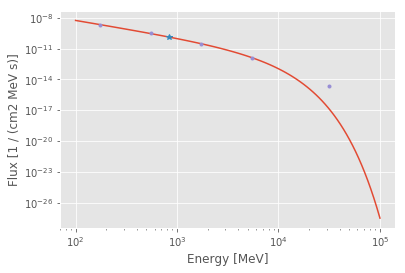

In [13]:
# Defining units
opts = dict(energy_unit='MeV', flux_unit='cm-2 s-1 MeV-1')

source.spectral_model.plot(source.energy_range, **opts)
# Spectral model used (PL, ECPL) based on the source's SpectrumType parameter

p = source.spectral_model.parameters

# Plot reference point
plt.plot(p['reference'].value, p['amplitude'].value, '*')

# Plot all data from source's FluxPoints
plt.errorbar(x=data['e_ref'],
             y = data['dnde'],
             yerr = data['dnde_err'],
             fmt='.'
            )

 ## Likelihood function - chi2

The chi2 function will determine the closeness of fit of our selected model (ECPL) to actual data.

In [14]:
# Code for parameters and spectral models has changed.
# Now there's a Parameter class, and you can call `.quantity` on it to get a quantity
source.spectral_model(p['reference'].quantity)

<Quantity 1.2799539206298505e-10 1 / (cm2 MeV s)>

In [32]:
# This isn't really needed, you could just call `SourceCatalogObject3FGL.evaluate`
# instead of rewriting the formula.
# I guess you did it for tutorial purposes? Keeping it for now

# Defining an ECPL model (same as Gammapy's)
def dnde_model_ecpl(energy, amplitude, index, energy_cut, reference):
    return amplitude * (energy / reference) ** (-index) * np.exp((reference -energy) / energy_cut)

In [33]:
# Defining chi2 function for this source
def chi2(amplitude, index, energy_cut):
    
    dnde_model = dnde_model_ecpl(
        energy=data['e_ref'],
        amplitude=amplitude,
        index=index,
        energy_cut=energy_cut,
        reference=p['reference'].value
    ) 

    chi = (data['dnde'] - dnde_model) / data['dnde_err']
    return np.sum(chi ** 2)

In [35]:
# Test one example evaluation - we want the same result as source.spectral_model
dnde_model_ecpl(
    energy=p['reference'].quantity,
    amplitude=p['amplitude'].quantity,
    index=p['index'].quantity,
    energy_cut=p['ecut'].quantity,
    reference=p['reference'].quantity,
)

<Quantity 1.2799539206298505e-10 1 / (cm2 MeV s)>

## ML fit with Minuit

Maximum likelihood (ML) analysis.

In [44]:
from iminuit import Minuit

pars = dict(amplitude=1.2799539206298505e-10, #amp value
            index=1.6358338594436646,         #idx value
            energy_cut=3042.514404296875
            )
minuit = Minuit(chi2, **pars)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:7: InitialParamWarning: errordef is not given. Default to 1.
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:7: InitialParamWarning: Parameter amplitude is floating but does not have initial step size. Assume 1.
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:7: InitialParamWarning: Parameter index is floating but does not have initial step size. Assume 1.
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:7: InitialParamWarning: Parameter energy_cut is floating but does not have initial step size. Assume 1.


In [45]:
minuit.print_initial_param()

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,amplitude,1.27995e-10,1,0,0,,,
2,index,1.63583,1,0,0,,,
3,energy_cut,3042.51,1,0,0,,,


In [46]:
minuit.migrad() # Performs the minimization

FCN = 55.11415067891237 
 TOTAL NCALL = 71 
 NCALLS = 71 
 
 
 EDM = 4.4493011180702984e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,amplitude,1.27917e-10,1.58353e-12,0,0,,,
2,index,1.64734,0.026096,0,0,,,
3,energy_cut,2953.55,132.179,0,0,,,


({'has_accurate_covar': True, 'has_covariance': True, 'has_made_posdef_covar': False, 'nfcn': 71, 'hesse_failed': False, 'edm': 4.4493011180702984e-07, 'up': 1.0, 'has_reached_call_limit': False, 'is_above_max_edm': False, 'has_valid_parameters': True, 'is_valid': True, 'has_posdef_covar': True, 'fval': 55.11415067891237},
 [{'is_const': False, 'is_fixed': False, 'has_limits': False, 'upper_limit': 0.0, 'name': 'amplitude', 'has_upper_limit': False, 'number': 0, 'error': 1.5835329798426252e-12, 'value': 1.2791749556592422e-10, 'lower_limit': 0.0, 'has_lower_limit': False},
  {'is_const': False, 'is_fixed': False, 'has_limits': False, 'upper_limit': 0.0, 'name': 'index', 'has_upper_limit': False, 'number': 1, 'error': 0.026095972909697878, 'value': 1.6473432003473054, 'lower_limit': 0.0, 'has_lower_limit': False},
  {'is_const': False, 'is_fixed': False, 'has_limits': False, 'upper_limit': 0.0, 'name': 'energy_cut', 'has_upper_limit': False, 'number': 2, 'error': 132.17876069891886, 'va

In [47]:
pprint(minuit.values)
pprint(minuit.errors)

{'amplitude': 1.2791749556592422e-10,
 'energy_cut': 2953.5540418278893,
 'index': 1.6473432003473054}
{'amplitude': 1.5835329798426252e-12,
 'energy_cut': 132.17876069891886,
 'index': 0.026095972909697878}


## Final plot

Adding the fitted model to the plot from above.

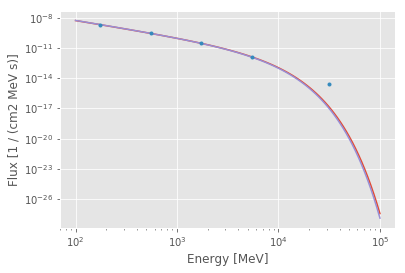

In [55]:
source.spectral_model.plot(source.energy_range, **opts)

plt.errorbar(x=data['e_ref'],
             y = data['dnde'],
             yerr = data['dnde_err'],
             fmt='.'
            )


from gammapy.utils.energy import Energy
energy = Energy.equal_log_spacing(
    emin=source.energy_range[0],
    emax=source.energy_range[1],
    nbins=100,
)


flux = dnde_model_ecpl(
    energy=energy.to('MeV').value,
    amplitude = minuit.values['amplitude'],
    index = minuit.values['index'],
    energy_cut = minuit.values['energy_cut'],
    reference=p['reference'].value,
)
plt.plot(energy, flux)